In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
from __future__ import division, print_function
import os
import gc
import numpy as np
import h5py as hdf
from scipy.misc import imread, imsave
import pyzdde.zdde as py
import pyzdde.arraytrace as at
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colorbar import make_axes
import matplotlib.patches as mpatches

# local modules
import iutils.plot.mplutils as mplu

In [4]:
#local module
%aimport geometric_model_zemax_commons
import geometric_model_zemax_commons as gm

In [5]:
%matplotlib inline
#%matplotlib notebook

In [6]:
curDir = os.getcwd()

In [7]:
# Helper functions

# NOTE: In this document the "PIVOT" is the pivot of the lens group

def find_surf_using_comment(ln, comment):
    for i in range(ln.zGetNumSurf()):
        if ln.zGetComment(i) == comment:
            break
    else:
        return -1
    return i

def get_pupil_pos_from_pivot(ln):
    """returns the distance of the ENPP and EXPP from the PIVOT
    """
    ln.zGetUpdate()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    enppSurf = find_surf_using_comment(ln, 'ENPP')
    exppSurf = find_surf_using_comment(ln, 'EXPP')

    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    enppZ = ln.zOperandValue('GLCZ', enppSurf) - pivotZ
    exppZ = ln.zOperandValue('GLCZ', exppSurf) - pivotZ
    return enppZ, exppZ, pivotZ

def get_image_pos_from_pivot(ln):
    """returns the distance of the image plane from the pivot along z-direction"""
    ln.zGetUpdate()
    imaSurf = ln.zGetNumSurf()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    imaZ = ln.zOperandValue('GLCZ', imaSurf) - pivotZ
    return imaZ

def get_obj_pos_from_pivot(ln):
    """returns the distance of the object point/plane from the pivot along z-direction"""
    ln.zGetUpdate()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    objZ = ln.zOperandValue('GLCZ', 0) - pivotZ
    return objZ

def set_lens_image_rotations(ln, thetaXLens, thetaYLens, thetaXImage, thetaYImage, cbLens, cbImage):
    """sets the lens and image plane rotation angles
    """
    ln.zSetSurfaceParameter(cbLens, 3, thetaXLens)
    ln.zSetSurfaceParameter(cbLens, 4, thetaYLens)
    ln.zSetSurfaceParameter(cbImage, 3, thetaXImage)
    ln.zSetSurfaceParameter(cbImage, 4, thetaYImage)
    ln.zGetUpdate()
    
def rotX(angle):
    """returns 3D matrix in SO(3) for rotating a vector about the +x-axis
    @param : angle in degrees
    """
    c, s = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    return np.array([[1.0, 0.0, 0.0], [0.0, c, -s], [0.0, s, c]])

def rotY(angle):
    """returns 3D matrix in SO(3) for rotating a vector about the +y-axis
    @param : angle in degrees
    """
    c, s = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    return np.array([[c, 0.0, s], [0.0, 1, 0.0], [-s, 0, c]])

In [8]:
# Helper function for saving figures
imgdir = os.path.join(curDir, 'images')
if not os.path.exists(imgdir):
    os.makedirs(imgdir)
    print("Created 'images' directory")


bSaveFigure = True
fig_format, fig_ext = 'png', '.png'
def saveFigure(figure, fig_name, DPI=200):
    if bSaveFigure:
        figname = os.path.join(imgdir, fig_name)
        print('figname:', figname)
        figure.savefig(figname, dpi=DPI, facecolor='white', edgecolor='white',
                       bbox_inches='tight', format=fig_format, pad_inches=0.03)

In [179]:
# Location of the Zemax lens files for this notebook
zmxdir = os.path.join(curDir, 'zmxfiles')
ln = pyz.createLink()

In [81]:
lens = "paraxialDoubleLens24mmFiniteConj_mp2.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)

0

In [82]:
#ln.zPushLens()

0

In [14]:
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity            500                                200              0
   1 PARAXIAL              -       3.636364                           9.382086              - Lens 1
 STO STANDARD       Infinity       16.36364                           7.142857              0 Stop
   3 PARAXIAL              -       13.17073                           11.35204              - Lens 2
 IMA STANDARD       Infinity                                          9.756098              0


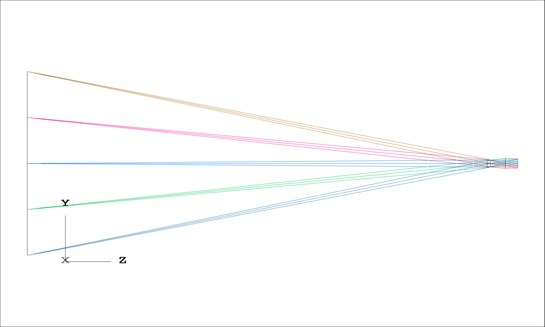

In [15]:
ln.ipzCaptureWindow('L3d')

In [16]:
# First order parameters
ln.ipzGetFirst()

Paraxial magnification : -0.0487804878
Real working F/#       : 3.168743031
Effective focal length : 24.0
Paraxial working F/#   : 3.129046563
Paraxial image height  : 4.87804878


In [17]:
# Pupil information
ln.ipzGetPupil()

Exit pupil position (from IMA)           : -49.17073171
Entrance pupil position (from surface 1) : 4.0
Aperture Type                            : Float by stop
Apodization factor                       : 0.0
Apodization type                         : None
Value (stop surface semi-diameter)       : 3.571428571
Exit pupil diameter                      : 15.71428571
Entrance pupil diameter                  : 7.857142857


In [18]:
ln.zGetPupilMagnification()

1.999999999490909

In [16]:
#ln.zPushLens()

In [17]:
# Draw ENPP, EXPP and cardinal surfaces
gm.draw_pupil_cardinal_planes(ln, firstDummySurfOff=20, push=True)

Textual information about the planes:

Exit pupil distance from IMG: -49.17073171
Entrance pupil from Surf 1 @ LDE: 24.0
Focal plane obj F from surf 1 @ LDE:  12.0 
Focal plane img F' from IMA:  -1.170732
Principal plane obj H from surf 1 @ LDE:  36.0 
Principal plane img H' from IMA:  -25.170732
Focal length:  24.0
Principal plane H to ENPP:  12.0
Principal plane H' to EXPP:  23.99999971
Principal plane H' to EXPP (abs.) calc. using lens equ.:  24.0
Principal plane H' to rear focal plane:  24.0
Principal plane H to front focal plane:  -24.0

Check "Skip rays to this surface" under "Draw Tab" of the surface property for the dummy and cardinal plane surfaces. See Docstring Notes for details.


In [24]:
# After making the required changes to the surface properties (skip rays)
# in the Zemax main application window, the file with the new surfaces
# to show the position of the pupils and cardinal planes was saved as
# paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawn.zmx
# For drawing the figure, we can use a stored copy in order to avoid
# manually changing surface properties in the LDE again and again
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawn.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

In [25]:
#ln.zPushLens()

In [26]:
# Insert appropriate coordinate breaks to tilt the lens
imgPPSurf = find_surf_using_comment(ln, "H'")
cb1, cb2 = gm.insert_cbs_to_tilt_lens(ln, lastSurf=imgPPSurf, firstSurf=2, pivot='ENPP', offset=5, push=True)
cb1, cb2

(4, 20)

As before, we need to do the following:

1. In the main Zemax application, check the "Skip rays to this surface" for the two dummy surfaces just inserted -- one preceding the first CB and second following the second CB -- in the "Draw Tab" under surface properties.

2. Fix the semi-diameters of the ENPP and EXPP surfaces so that they don't change when the lens rotates.

3. Ensure that the global reference surface is either the PIVOT surface (recommended), image plane or the untilted object plane.

4. Also, ensure that you are displaying all the appropriate surfaces in the LDE. 

In [9]:
## TO DO
# set the PIVOT surface to 

pivot_surf = find_surf_using_comment(ln, 'PIVOT')
pivot_surf
#if pivot_surf:
#    pass
#else:
#    print("Couldn't find)
#ln.zSet

-1

In [180]:
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawnWdRotAboutENPPplusOffset.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
    cb1 = 4
else:
    ln.zGetRefresh()

In [11]:
#ln.zPushLens()

<font color='red'>**Important!**</font> 

1. Before we perform any ray tracing to plot the intersection of the chief-ray(s) with the image plane, we must ensure that the (paraxial) *ray-aiming* feature in Zemax is turned on. This is important because during ray tracing Zemax determines the direction cosines of the rays that emerges from the object surface based on the paraxial entrance pupil location. However, the paraxial calculation used to compute the entrance pupil ignores tilts and decenters of the surfaces including the stop. Therefore, it is very likely that a "chief-ray", which is defined as the ray through the center of the stop (and virtually through the centers of the entrance and exit pupils in an aberration-free optical system), may not be really traced.

2. The coordinates (of ray intersection with a surface) returned by `zGetTrace()` are with respect to the surface's reference frame instead of the global reference frame.  

In [12]:
sysProp = ln.zGetSystem()
ln.zSetSystem(unitCode=sysProp.unitCode, 
              stopSurf=sysProp.stopSurf, 
              rayAimingType=1, 
              globalRefSurf=sysProp.globalRefSurf)

(22, 0, 12, 1, 1, 0, 20.0, 1, 3)

Without tilting the image surface

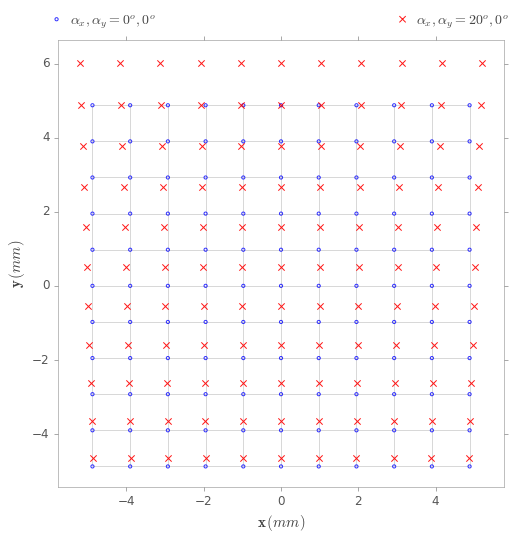

In [43]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 0)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

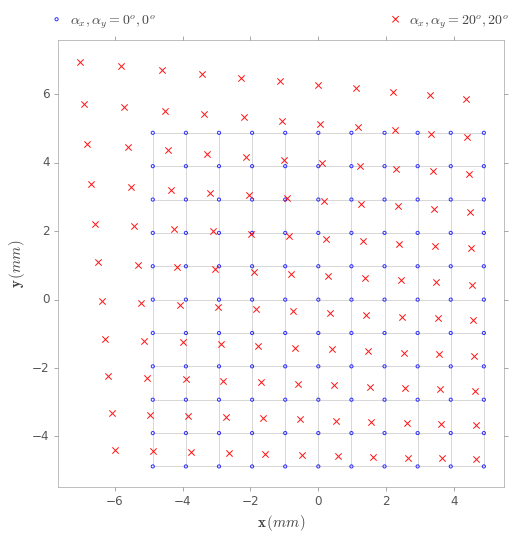

In [44]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 20)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

In [181]:
# insert coordinate break to tilt image surface
imaSurf = ln.zGetNumSurf()
ln.zInsertCoordinateBreak(surfNum=imaSurf, xtilt=15.0)
#paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawnWdRotAboutENPPplusOffsetIIMATilt.zmx

0

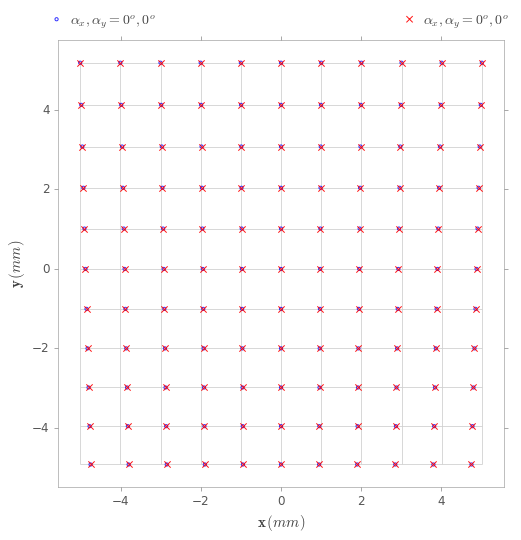

In [46]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (0, 0)]  # no lens tilt
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

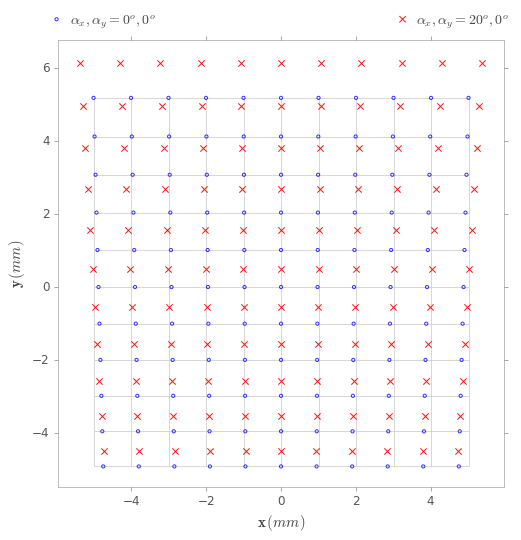

In [47]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 0)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

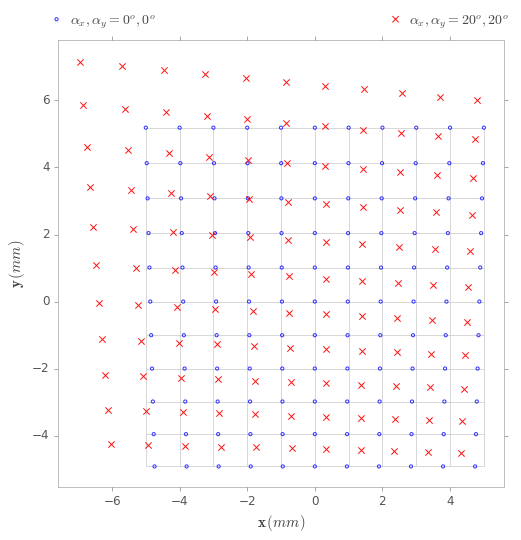

In [48]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 20)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

In [20]:
#ln.close()

Verification of the equation:


$$
\acute{{\bf x}} = \acute{d}_e \, {\bf r} _{l,3} + 
\frac{\left( \hat{{\bf n}}_i (3) \, \acute{z}_o  - \acute{d}_e \, \hat{{\bf n}}_i^T \, {\bf r} _{l,3} \right)}{\hat{{\bf n}}_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})}
R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3}) \,\,
$$


In the above equation both the object point and the image point are represented with respect to the camera frame ${C}$. 

$$
^{c}\acute{{\bf x}} = R_i \, ^{i}\acute{{\bf x}} + {\bf t}_i
$$

where, ${\bf t}_i = [0, 0, \acute{z}_o]^T$

Therefore, the coordinates of the image point in the image frame is


$$
^{i}\acute{{\bf x}} = R^T_i \,\left( ^{c}\acute{{\bf x}} - {\bf t}_i \right)
$$


We can combine the above equation to write:

$$
^{i}\acute{{\bf x}} = R_i^T \left( \acute{d}_e \, {\bf r} _{l,3}  - {\bf t}_i \right)  + 
\frac{\left( \hat{{\bf n}}_i (3) \, \acute{z}_o  - \acute{d}_e \, \hat{{\bf n}}_i^T \, {\bf r} _{l,3} \right)}{\hat{{\bf n}}_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})}
R_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3}) \,\,
$$




In [183]:
# create field coordinates for ray tracing
# NOTE: 
# The following field definitions in the LDE are assumed:
# 1. The field normalization is RADIAL
# 2. The field type is object height

fieldDef = ln.zGetField(0)
assert fieldDef.type == 1       # ensure type is object height
assert fieldDef.normMethod == 0 # ensure radial normalization

# maximum radial field
fR = fieldDef.maxX # or maxY


In [184]:
## Get the positions of the ENPP, EXPP and Image plane w.r.t. the pivot
## Get the pupil magnification mp
cb1Lens = 4    # coordinate break surface number (assume that it is known)
cbImage = 22   # coordinate break surface number (assume that it is known)

# first ensure that the lens is not rotated
set_lens_image_rotations(ln, 0, 0, 0, 0, cb1Lens, cbImage)

zoDash = get_image_pos_from_pivot(ln)
de, deDash, pp = get_pupil_pos_from_pivot(ln)
mp = ln.zGetPupilMagnification()

print('Pivot position:', pp)
print('ENPP position (de):', de)
print('EXPP position (deDash):', deDash)
print('Image position (zoDash):', zoDash)
print('Pupil magnification (mp):', mp)

Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -25.0
Image position (zoDash): 24.1707317
Pupil magnification (mp): 1.99999999949


In [185]:
## Set the elemental rotations of the lens and image plane @ Zemax
# note that in Zemax the rotations are intrinsic, i.e. rotations subsequent to 
# the first rotation is always w.r.t. the new x-y-z axis.
# Also, if the order flag in the first coordinate break is 0 (default), then the
# order of rotations is: x-y'-z"

thetaXLens, thetaYLens = -20, 10
thetaXImage, thetaYImage = 15, -5
set_lens_image_rotations(ln, thetaXLens, thetaYLens, thetaXImage, thetaYImage, cb1Lens, cbImage)

In [187]:
#ln.zPushLens()

In [18]:
# Construct intrinsic rotation matrix  x-y'-z"
# This is equivalent to composition of extrinsic elemental rotations: z-y-x

Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
rl3 = Rl[:,2] # optical axis
Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
ni = Ri[:, 2] # normal to the image plane

In [19]:
# Verify using ray-tracing in Zemax
# Ensure that "ray-aiming" is on

assert ln.zGetSystem().rayAimingType
z = get_obj_pos_from_pivot(ln)
normObjPts = np.array([[ 0.0000,  0.0000], 
                       [ 0.1000, -0.1000],
                       [-0.5000,  0.5000],
                       [ 0.7071,  0.7071],
                       [ 1.0000,  0.0000],
                       [ 0.0000,  1.0000],
                       [ 1.0000,  1.0000]
                       ])

Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
numr = ni[2]*zoDash - deDash*np.dot(ni, rl3)
rmrt = np.dot(Rl , np.dot(Mp, Rl.T))

print('\t  X\t\t\t    x_computed\t\t   x_ray_trace\t\t  err(delx, dely)')
for pts in normObjPts:
    X = np.hstack((fR*pts, [z,]))
    A =  np.dot(rmrt, X - de*rl3)
    deno = np.dot(ni, A)
    x_c_est = deDash*rl3 + (numr/deno)*A   # estimate of x in camera frame
    x_est = np.dot(Ri.T, (x_c_est - np.array([0, 0, zoDash]).T))  # estimate of x in the image frame
    
    # ray trace
    rt = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=pts[0], hy=pts[1], px=0, py=0)
    print('({: 7.2f}, {: 7.2f}, {: 5.1f}) '
          '({: .4f}, {: .4f}, {: .1f}) '
          '({: .4f}, {: .4f}, {: .1f}) '
          '({:0.1e}, {:0.1e}, {:0.1e})'
          .format(X[0], X[1], X[2],
                  x_est[0], x_est[1], x_est[2],
                  rt.x, rt.y, rt.z, 
                  abs(x_est[0] - rt.x), abs(x_est[1] - rt.y), abs(x_est[2] - rt.z)))

	  X			    x_computed		   x_ray_trace		  err(delx, dely)
(   0.00,    0.00, -509.0) (-0.3108, -0.6291,  0.0) (-0.3108, -0.6291,  0.0) (1.8e-09, 3.1e-09, 7.5e-15)
(  10.00,  -10.00, -509.0) (-0.8003, -0.0863, -0.0) (-0.8003, -0.0863,  0.0) (2.1e-09, 2.7e-09, 3.0e-15)
( -50.00,   50.00, -509.0) ( 2.1291, -3.3352,  0.0) ( 2.1291, -3.3352,  0.0) (1.2e-09, 3.2e-09, 2.9e-15)
(  70.71,   70.71, -509.0) (-4.2013, -5.0221, -0.0) (-4.2013, -5.0221,  0.0) (2.6e-09, 5.1e-09, 4.7e-15)
( 100.00,    0.00, -509.0) (-5.5251, -1.0101, -0.0) (-5.5251, -1.0101,  0.0) (1.3e-09, 8.4e-09, 3.1e-15)
(   0.00,  100.00, -509.0) (-0.6031, -6.4387, -0.0) (-0.6031, -6.4387,  0.0) (2.2e-09, 4.0e-09, 2.2e-16)
( 100.00,  100.00, -509.0) (-5.8238, -6.8542,  0.0) (-5.8238, -6.8542,  0.0) (5.6e-10, 2.5e-10, 2.2e-15)


In [21]:
ln.close()

### Patterns of image points to show the nature of image field

First we need to find the distances of the ENPP and EXPP from the PIVOT (of the lens group) point. The following block of code is used to retrieve this information. Note that it requires Zemax in running state.

Please make sure that there is no unsaved file in the Zemax DDE server, the following block of code will load files erasing any unsaved file that is present in the DDE server.

In [132]:
# Execute this cell only if Zemax is not already running
ln = pyz.createLink()

In [135]:
# This cell requires a running Zemax  application
def print_pupil_distances_from_lens_pivot_point(pivotOffset=5):
    """
    @param : pivotOffset (real) : offset of the lens group pivot point from the ENPP
    """
    lensFiles = ["paraxialDoubleLens24mmFiniteConj_mp1.zmx",
                 "paraxialDoubleLens24mmFiniteConj_mp2.zmx",
                 "paraxialDoubleLens24mmFiniteConj_mpdot55.zmx"]

    zmxdir = os.path.join(curDir, 'zmxfiles')
    for lens in lensFiles:
        lensPath = os.path.join(zmxdir, lens)
        ln.zLoadFile(lensPath)

        # draw cardinal and pupil planes
        gm.draw_pupil_cardinal_planes(ln, firstDummySurfOff=20, push=True, printInfo=False)

        # insert CBs
        imgPPSurf = find_surf_using_comment(ln, "H'")
        objPPSurf = find_surf_using_comment(ln, "H")
        cb1, cb2 = gm.insert_cbs_to_tilt_lens(ln, lastSurf=imgPPSurf, firstSurf=objPPSurf-1, 
                                              pivot='ENPP', offset=pivotOffset, push=True)

        # change Global reference surface to the PIVOT surface
        pivotSurf = find_surf_using_comment(ln, 'PIVOT')
        sysProp = ln.zGetSystem()
        _ = ln.zSetSystem(unitCode=sysProp.unitCode, 
                          stopSurf=sysProp.stopSurf, 
                          rayAimingType=sysProp.rayAimingType, 
                          globalRefSurf=pivotSurf)
        # retrieve and print data
        zoDash = get_image_pos_from_pivot(ln)
        de, deDash, pp = get_pupil_pos_from_pivot(ln)
        mp = ln.zGetPupilMagnification()

        print('\nLens:', lens)
        print('Pupil magnification (mp):', mp)
        print('Pivot position:', pp)
        print('ENPP position (de):', de)
        print('EXPP position (deDash):', deDash)
        print('Image position (zoDash):', zoDash)

In [136]:
# This cell requires a running Zemax  application
# Offset of lens group PIVOT point from ENPP = 5 mm
print_pupil_distances_from_lens_pivot_point(pivotOffset=5)


Lens: paraxialDoubleLens24mmFiniteConj_mp1.zmx
Pupil magnification (mp): 1.0
Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -13.0
Image position (zoDash): 12.1707317

Lens: paraxialDoubleLens24mmFiniteConj_mp2.zmx
Pupil magnification (mp): 1.99999999949
Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -25.0
Image position (zoDash): 24.1707317

Lens: paraxialDoubleLens24mmFiniteConj_mpdot55.zmx
Pupil magnification (mp): 0.55000000037
Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -21.8363636
Image position (zoDash): -7.4656319


In [137]:
# This cell requires a running Zemax  application
# Offset of lens group PIVOT point from ENPP = 0 mm
print_pupil_distances_from_lens_pivot_point(pivotOffset=0)


Lens: paraxialDoubleLens24mmFiniteConj_mp1.zmx
Pupil magnification (mp): 1.0
Pivot position: 0.0
ENPP position (de): 0.0
EXPP position (deDash): -8.0
Image position (zoDash): 17.1707317

Lens: paraxialDoubleLens24mmFiniteConj_mp2.zmx
Pupil magnification (mp): 1.99999999949
Pivot position: 0.0
ENPP position (de): 0.0
EXPP position (deDash): -20.0
Image position (zoDash): 29.1707317

Lens: paraxialDoubleLens24mmFiniteConj_mpdot55.zmx
Pupil magnification (mp): 0.55000000037
Pivot position: 0.0
ENPP position (de): 0.0
EXPP position (deDash): -16.8363636
Image position (zoDash): -2.4656319


In [188]:
# This cell requires a running Zemax  application
ln.close()

The following sections of the code can run without Zemax running.

In [9]:
def get_image_coordinates(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash):
    """returns the coordinates of the chief-ray-image-plane intersections in the image surface
    reference frame
    
    Parameters
    ----------
    X : ndarray
        3xN array of object coordinates (in camera frame)
    
    
    """
    # construct lens rotation matrix and optical axis vector
    Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
    rl3 = Rl[:, 2, np.newaxis]  # optical axis
    # construct image plane rotation matrix and image plane normal
    Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
    ni = Ri[:, 2, np.newaxis]   # normal to the image plane
    # pupil magnification matrix
    Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
    numr = ni[2]*zoDash - deDash*np.dot(ni.T, rl3)
    rmrt = np.dot(Rl , np.dot(Mp, Rl.T))
    A =  np.dot(rmrt, X - de*rl3)  # [A]=3xn
    deno = np.dot(ni.T, A)    # [deno]=1xn
    x_c = deDash*rl3 + (numr/deno)*A   # x in camera frame
    x_i = np.dot(Ri.T, (x_c - np.array([[0, 0, zoDash]]).T))  # x in the image frame
    return x_i

# implementation of the second expression (equivalent)

def get_image_coordinates_v2(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash):
    """returns the coordinates of the chief-ray-image-plane intersections in the image surface
    reference frame
    
    Parameters
    ----------
    X : ndarray
        3xN array of object coordinates (in camera frame)
    
    
    """
    # construct lens rotation matrix and optical axis vector
    Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
    rl3 = Rl[:, 2, np.newaxis]  # optical axis
    # construct image plane rotation matrix and image plane normal
    Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
    ti = np.array([[0, 0, zoDash]]).T
    #ri3 = Ri[:, 2, np.newaxis]   # same as ni
    ni = Ri[:, 2, np.newaxis]   # normal to the image plane
    # pupil magnification matrix
    Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
    numr = ni[2]*zoDash - deDash*np.dot(ni.T, rl3)
    rmrt = np.dot(Rl , np.dot(Mp, Rl.T))
    A =  np.dot(rmrt, X - de*rl3)  # [A]=3xn
    deno = np.dot(ni.T, A)    # [deno]=1xn 
    
    x_i = np.dot(Ri.T, (deDash*rl3 - ti)) + (numr/deno)* np.dot(Ri.T, A)  # x in image frame
    return x_i

In [10]:
z = -509.0
fR= 100
de = -5.0
deDash = -25.0
zoDash = 24.1707317
mp = 2.0

# normalized field coordinate grid
nx = [-1.0, -0.98, -0.7071, -0.5, -0.25, -0.15, 0.0, 0.15, 0.25, 0.5, 0.7071, 0.98, 1.0]
n = len(nx)
hx, hy = np.meshgrid(nx, nx)
X = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), z*np.ones((1, n**2))))

#
thetaXLens, thetaYLens =  5., 10.
thetaXImage, thetaYImage =  5, -2
x1 = get_image_coordinates(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x2 = get_image_coordinates_v2(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

assert np.sum(x1 - x2) < 10e-10

print("The two functions are equivalent (w.r.t. the tested points)!")

The two functions are equivalent (w.r.t. the tested points)!


#### Plots

figname: C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\images\centroid_translations_3.png


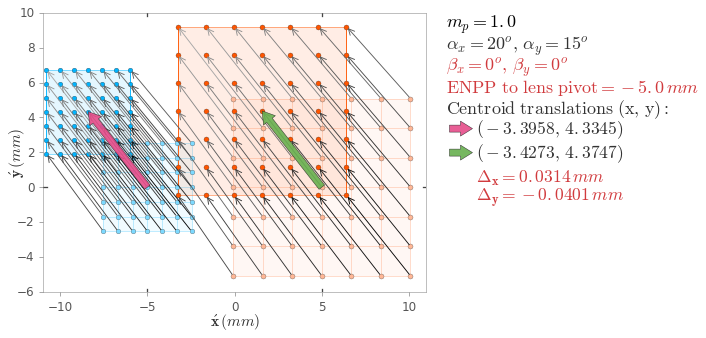

In [300]:

# normalized field coordinates (common for all the optical systems)
n = 7   # THIS NUMBER SHOULD BE ODD, in order to have the on-axis point (0,0)
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
fR= 100 

# for drawing the outer boundary
nB = 15
nxB = np.linspace(-1, 1, nB)    
hxB, hyB = np.meshgrid(nxB, nxB)

# *****************************
#       PLOT SETTINGS
# ****************************
# Set optical system
OPTICAL_SYSTEM = 2  # mp(1)=0.55 , mp(2)=1.0 or mp(not(1,2))=2.0
PIVOT_OFFSET = 5    # 0 or 5 mm from the ENPP (actual offset is -5)
COMPARE_PIVOT_OFFSET = True   # set OPTICAL_SYSTEM=2 set the particular PIVOT_OFFSET value = 0
TILT_UNOFFSET = False
SHOW_COMMON_LEGEND = False # generally true only for the first image in a squence
# ******************************

## Set tilts
if COMPARE_PIVOT_OFFSET:
    # to compare Pivot offset
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 0, 0 # with Pivot_offset = 0, mp=1
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 5, 5 # with Pivot_offset = 0, mp=1
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 0, 0 # with Pivot_offset = 5, mp=1
else:
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  0, 0, 20, 0
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 0, 0
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  5, 0, 20, 0

assert PIVOT_OFFSET in (0, 5)

if OPTICAL_SYSTEM == 1: # mp = 0.550000000
    # Optical System 1
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -21.8363636 if PIVOT_OFFSET else -16.8363636
    zoDash = -7.4656319 if PIVOT_OFFSET else -2.4656319
    mp = 0.55
elif OPTICAL_SYSTEM == 2: # mp = 1.0
    # Optical System 2
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -13.0 if PIVOT_OFFSET else -8.0
    zoDash = 12.1707317 if PIVOT_OFFSET else 17.1707317
    mp = 1.0
else: # mp = 2.0
    # Optical System 3
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -25.0 if PIVOT_OFFSET else -20.0
    zoDash = 24.1707317 if PIVOT_OFFSET else 29.1707317
    mp = 2.0

# Object planes (zFar and zNear have nothing to do with DOF, they are just two planes in object space)
#zNear = -509.0  
#zFar = -809.0

zNear = -500.0
zFar = -1000.0


# COMPUTATOINS
# ###########

# points @ object plane Z1
XNear = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), zNear*np.ones((1, n**2))))
XNearB = np.vstack((fR*hxB.reshape(1, nB**2), fR*hyB.reshape(1, nB**2), zNear*np.ones((1, nB**2))))

# image points for zero tilts @ object plane Z1
x1 = get_image_coordinates(XNear, 0, 0, 0, 0, mp, zoDash, de, deDash)
x1B = get_image_coordinates(XNearB, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x2 = get_image_coordinates(XNear, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x2B = get_image_coordinates(XNearB, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

# points @ object plane Z2
XFar = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), zFar*np.ones((1, n**2))))
XFarB = np.vstack((fR*hxB.reshape(1, nB**2), fR*hyB.reshape(1, nB**2), zFar*np.ones((1, nB**2))))

# image points for zero tilts @ object plane Z2 
x3 = get_image_coordinates_v2(XFar, 0, 0, 0, 0, mp, zoDash, de, deDash)
x3B = get_image_coordinates_v2(XFarB, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x4 = get_image_coordinates_v2(XFar, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x4B = get_image_coordinates_v2(XFarB, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)


# compensation for tilt offset
tOffset = x2[:2, n**2 // 2] - x1[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 
#tOffset = x4[:2, n**2 // 2] - x3[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 

# displacement of center of mass of block @ Z1
cmDisplaceZ1x = np.sum(x2[0, :]/n**2) - np.sum(x1[0, :]/n**2)
cmDisplaceZ1y = np.sum(x2[1, :]/n**2) - np.sum(x1[1, :]/n**2)

# displacement of center of mass of block @ Z2
cmDisplaceZ2x = np.sum(x4[0, :]/n**2) - np.sum(x3[0, :]/n**2)
cmDisplaceZ2y = np.sum(x4[1, :]/n**2) - np.sum(x3[1, :]/n**2)

#print('CM displace @ Z1 = ({:5f}, {:5f})'.format(cmDisplaceZ1x, cmDisplaceZ1y))
#print('CM displace @ Z2 = ({:5f}, {:5f})'.format(cmDisplaceZ2x, cmDisplaceZ2y))

# FIGURE
# ######

#fig, ax = plt.subplots(1, 1, figsize=(8.45, 5), dpi=200)
fig, ax = plt.subplots(1, 1, figsize=(8.45, 5.), dpi=200)

grid_col_notilt_z1 = '#FFB796'
grid_col_tilt_z1 = '#FF5500' #'#FF7433'
grid_col_notilt_z2 = '#7CD9FF' 
grid_col_tilt_z2 = '#00B4FF'


def get_v12NormMin_v12NormMax(a, b):
    v1 = np.hstack((a[0,:].reshape(n**2, 1), a[1,:].reshape(n**2, 1)))
    v2 = np.hstack((b[0,:].reshape(n**2, 1), b[1,:].reshape(n**2, 1)))
    v12Norm = np.linalg.norm(v2-v1, axis=1)
    return np.min(v12Norm), np.max(v12Norm)

def get_gray_level(vNorm, v12NormMin, v12NormMax):
    """
    Notes:
    where is vNorm in the scale between v12NormMin and v12NormMax?
    we can write: v12NormMin * (1 - a) + v12NormMax * a = vNorm
    Furthermore,
    if gl1 and gl2 are two gray levels (gl1 < gl2) and 0 <= gl1, gl2 <= 1
    gl = a * (gl2 - gl1) + gl1
    However, since we want darker shade to represent larger norm value,
    we return 1 - gl
    """
    a = (vNorm - v12NormMin)/(v12NormMax - v12NormMin)
    gl1, gl2 = 0.35, 0.99
    gl = a * (gl2 - gl1) + gl1
    return 1.0 - gl


# Object plane at Z1
# ------------------
# displace plot for Z1 and Z2
xOffset, yOffset = 5, 0

ax.scatter(x1[0, :] + xOffset, x1[1, :] + yOffset, marker='o', s=25, 
           facecolors=grid_col_notilt_z1, edgecolors='#444444', lw=0.3, alpha=1.0, zorder=13,
           label=r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'.format(-500))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x1[0, i*n:(i+1)*n] + xOffset, 
                     y1=x1[1, i*n:(i+1)*n] + yOffset, 
                     y2=x1[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=grid_col_notilt_z1, edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x1[0, :][:n] + xOffset
yGridPts = x1[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=grid_col_notilt_z1, 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=grid_col_notilt_z1, 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x2[0, :] + xOffset - tOffset[0], x2[1, :] + yOffset - tOffset[1], 
           marker='o', s=25, facecolors=grid_col_tilt_z1, edgecolor='#333333', 
           lw=0.3, alpha=1.0, zorder=13, clip_on=False, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={}\, \it{{mm}}$'.format(-500))

# shade region to show the span of the grid of points
for i in range(nB-1):
    x_row1 = x2B[0, i*nB:(i+1)*nB] + xOffset
    x_row2 = x2B[0, (i+1)*nB:(i+2)*nB] + xOffset
    y_row1 = x2B[1, i*nB:(i+1)*nB] + yOffset
    y_row2 = x2B[1, (i+1)*nB:(i+2)*nB] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=grid_col_tilt_z1, 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)


# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):    
    minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x1, x2)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x2[0, i] - x1[0, i])**2 +  (x2[1, i] - x1[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x2[0, i] + xOffset, x2[1, i] + yOffset), 
                    xytext=(x1[0, i] + xOffset, x1[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color=arrCol, linewidth=0.9, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)
    
# draw outer boundery
ax.plot(x2B[0, :nB] + xOffset - tOffset[0], x2B[1, :nB], color=grid_col_tilt_z1, 
        lw=0.9, zorder=2, alpha=0.5, clip_on=False) # top
ax.plot(x2B[0, -nB::] + xOffset - tOffset[0], x2B[1, -nB::], color=grid_col_tilt_z1, 
        lw=0.9, zorder=2, alpha=0.5,  clip_on=False) # bottom
ax.plot(x2B[0, nB-1::nB] + xOffset - tOffset[0], x2B[1, nB-1::nB], color=grid_col_tilt_z1, 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # left side
ax.plot(x2B[0, ::nB] + xOffset - tOffset[0], x2B[1, ::nB], color=grid_col_tilt_z1, 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # right side

if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x2[0, :]/n**2) + xOffset, np.sum(x2[1, :]/n**2) + yOffset), 
                xytext=(np.sum(x1[0, :]/n**2) + xOffset, np.sum(x1[1, :]/n**2) + yOffset),
                arrowprops=dict(fc='#68B04F', ec='#222222', linewidth=0.5, headwidth=15, width=7, alpha=0.9),
                annotation_clip=False, zorder=16)

# Object plane at Z2
# ------------------
xOffset, yOffset = -5, 0

ax.scatter(x3[0, :] + xOffset, x3[1, :] + yOffset, marker='o', s=22, 
           facecolors=grid_col_notilt_z2, edgecolors='#444444', lw=0.3, alpha=1.0, zorder=12,
           label=r'$\rm{{Frontoparallel}} \,;\, \, z_o={}\,\it{{mm}}$'.format(-1000))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x3[0, i*n:(i+1)*n] + xOffset, 
                     y1=x3[1, i*n:(i+1)*n] + yOffset, 
                     y2=x3[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=grid_col_notilt_z2, edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x3[0, :][:n] + xOffset
yGridPts = x3[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=grid_col_notilt_z2, 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=grid_col_notilt_z2, 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x4[0, :] + xOffset - tOffset[0], x4[1, :] + yOffset - tOffset[1], 
           marker='o', s=22, facecolors=grid_col_tilt_z2, edgecolor='#333333', 
           lw=0.3, alpha=1.0, clip_on=False, zorder=12, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={}\, \it{{mm}}$'.format(-1000))

# shade region to show the span of the grid of points
for i in range(nB-1):
    x_row1 = x4B[0, i*nB:(i+1)*nB] + xOffset
    x_row2 = x4B[0, (i+1)*nB:(i+2)*nB] + xOffset
    y_row1 = x4B[1, i*nB:(i+1)*nB] + yOffset
    y_row2 = x4B[1, (i+1)*nB:(i+2)*nB] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=grid_col_tilt_z2, 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):
    minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x3, x4)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x4[0, i] - x3[0, i])**2 +  (x4[1, i] - x3[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x4[0, i] + xOffset, x4[1, i] + yOffset), 
                    xytext=(x3[0, i] + xOffset, x3[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color= arrCol, linewidth=0.9, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)

# draw outer boundery
ax.plot(x4B[0, :nB] + xOffset - tOffset[0], x4B[1, :nB], color=grid_col_tilt_z2, 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # top
ax.plot(x4B[0, -nB::] + xOffset - tOffset[0], x4B[1, -nB::], color=grid_col_tilt_z2, 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # bottom
ax.plot(x4B[0, nB-1::nB] + xOffset - tOffset[0], x4B[1, nB-1::nB], color=grid_col_tilt_z2, 
        clip_on=False, alpha=0.9, lw=1.0, zorder=2) # left side
ax.plot(x4B[0, ::nB] + xOffset - tOffset[0], x4B[1, ::nB], color=grid_col_tilt_z2, 
        lw=1.0, alpha=0.9, clip_on=False, zorder=2) # right side
        
if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x4[0, :]/n**2) + xOffset, np.sum(x4[1, :]/n**2) + yOffset), 
                   xytext=(np.sum(x3[0, :]/n**2) + xOffset, np.sum(x3[1, :]/n**2) + yOffset),
                 arrowprops=dict(fc='#e64d8a', ec='#222222', linewidth=0.5, headwidth=15, width=7, alpha=0.9),
                        annotation_clip=False, zorder=16) 
##
if COMPARE_PIVOT_OFFSET:
    ax.set_xlim(-11, 11)
    ax.set_ylim(-6, 10)
else:
    ax.set_xlim(-9, 11)
    ax.set_ylim(-6, 8)
ax.set_aspect('equal')
#ax.axis('tight')
ax.set_ylabel(r'$\'{\bf{y}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-10)
ax.set_xlabel(r'$\'{\bf{x}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-2)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#ax.grid()

# draw center markers
ax.axvline(x=xOffset, ymin=0, ymax=0.01, color='#444444')
ax.axvline(x=-xOffset, ymin=0, ymax=0.01, color='#444444')
ax.axvline(x=xOffset, ymin=0.99, ymax=1, color='#444444')
ax.axvline(x=-xOffset, ymin=0.99, ymax=1, color='#444444')

ax.axhline(y=yOffset, xmin=0, xmax=0.01, color='#444444')
ax.axhline(y=yOffset, xmin=0.99, xmax=1, color='#444444')

txt1 = r'$m_p ={}$'.format(mp)
txt2 = r'$\alpha_{{x}} ={}^o, \, \alpha_{{y}} ={}^o$'.format(thetaXLens, thetaYLens)   
txt3 = r'$\beta_{{x}} ={}^o, \, \beta_{{y}} ={}^o$'.format(thetaXImage, thetaYImage) 
txt4 = r'$\rm{{ENPP}}\,\,\rm{{to}}\,\,\rm{{lens}}\,\,\rm{{pivot}} =  {} \,\it{{mm}}$'.format(de)
txt5 = r'$\rm{Centroid}\,\, \rm{translations} \,\, \rm{(x,}\, \rm{y):}$'
s1, s2 = '{: .4f}'.format(cmDisplaceZ2x), '{: .4f}'.format(cmDisplaceZ2y)
txt6 = r'$({},\, {})$'.format(s1, s2)
s1, s2 = '{: .4f}'.format(cmDisplaceZ1x), '{: .4f}'.format(cmDisplaceZ1y)
txt7 = r'$({},\, {})$'.format(s1, s2)
txt8 = r'$\bf{{\Delta_x = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2x - cmDisplaceZ1x)
txt9 = r'$\bf{{\Delta_y = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2y - cmDisplaceZ1y)


# at top right (outside the axes)

txtOff = -0.31 if SHOW_COMMON_LEGEND else 0
transArrowLegOff = 0 if SHOW_COMMON_LEGEND else 0.0899

if not COMPARE_PIVOT_OFFSET:
    fig.text(0.86, 0.86 + txtOff, txt1, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
    fig.text(0.86, 0.74 + txtOff, txt3, fontsize=18, color='#333333')
    fig.text(0.86, 0.68 + txtOff, txt4, fontsize=18, color='#333333')
else:
    fig.text(0.86, 0.86 + txtOff, txt1, fontsize=18, color='#000000')
    fig.text(0.86, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
    fig.text(0.86, 0.74 + txtOff, txt3, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.68 + txtOff, txt4, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.62 + txtOff, txt5, fontsize=18, color='#333333')
    fig.text(0.91, 0.566 + txtOff, txt6, fontsize=17.5, color='#333333')
    fig.text(0.91, 0.499 + txtOff, txt7, fontsize=17.5, color='#333333')
    ax.annotate("", xy=(1.12, 0.495 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
                xytext=(1.06, 0.495 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
                arrowprops=dict(fc='#e64d8a', ec='#222222', linewidth=0.5, headwidth=15, 
                                width=7, alpha=0.9,),      
                annotation_clip=False, zorder=12)
    ax.annotate("", xy=(1.12, 0.409 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
                xytext=(1.06, 0.409 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
                arrowprops=dict(fc='#68B04F', ec='#222222', linewidth=0.5, headwidth=15,
                                width=7, alpha=0.9),      
                annotation_clip=False, zorder=12)
    fig.text(0.91, 0.43 + txtOff, txt8, fontsize=17.5, color='#D13A3D')
    fig.text(0.91, 0.38 + txtOff, txt9, fontsize=17.5, color='#D13A3D')
    
# Legend
#r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'
if SHOW_COMMON_LEGEND:
    t = 0 if COMPARE_PIVOT_OFFSET else -0.022  # adjustment required because xlims are not exactly the same
    ax.annotate(r'$\rm{Translation}\,\, \rm{(darker}\,\,\rm{is}\,\,\rm{larger)}$', 
                xy=(1.035 + t, 0.65), xycoords='axes fraction',
                xytext=(1.082 + t, 0.65), textcoords='axes fraction', 
                arrowprops=dict(arrowstyle='<-', color= '0.2', linewidth=0.9, mutation_scale=15), 
                va='center', annotation_clip=False, fontsize=16.5, zorder=15)

    ax.legend(fontsize=16.5, scatterpoints=1, markerscale=1.12, scatteryoffsets=[0.5],
              ncol=1, loc='upper right', bbox_to_anchor=(1.287, 0.945), labelspacing=0.14,
              bbox_transform=fig.transFigure, handletextpad=0.35, handlelength=0.5)

# Save the figure
#saveFigure(fig, 'distortion_grid_33.png')
#saveFigure(fig, 'centroid_translations_3.png')

plt.show()

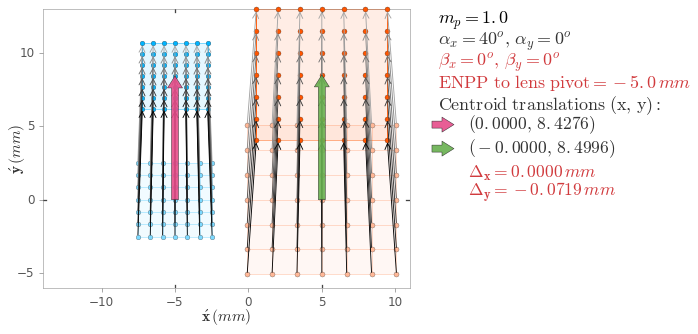

In [301]:
# copy of the previous code cell (had to do it; should have turned it into a function ....)
# to generate plots (for chapter 5) to compare image field shifts due ot lens-only rotation about ENPP


# normalized field coordinates (common for all the optical systems)
n = 7   # THIS NUMBER SHOULD BE ODD, in order to have the on-axis point (0,0)
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
fR= 100 

# for drawing the outer boundary
nB = 15
nxB = np.linspace(-1, 1, nB)    
hxB, hyB = np.meshgrid(nxB, nxB)

# *****************************
#       PLOT SETTINGS
# ****************************
# Set optical system
OPTICAL_SYSTEM = 2  # mp(1)=0.55 , mp(2)=1.0 or mp(not(1,2))=2.0
PIVOT_OFFSET = 5    # 0 or 5 mm from the ENPP (actual offset is -5)
COMPARE_PIVOT_OFFSET = True   # set OPTICAL_SYSTEM=2 set the particular PIVOT_OFFSET value = 0
TILT_UNOFFSET = False
SHOW_COMMON_LEGEND = False # generally true only for the first image in a squence
# ******************************

## Set tilts
if COMPARE_PIVOT_OFFSET:
    # to compare Pivot offset
    #thetaXLens, thetaYLens, thetaXImage, thetaYImage =  20, 15, 0, 0 # with Pivot_offset = 0, mp=0.55
    thetaXLens, thetaYLens, thetaXImage, thetaYImage =  40, 0, 0, 0 # with Pivot_offset = 5, mp=1
else:
    pass

assert PIVOT_OFFSET in (0, 5)

if OPTICAL_SYSTEM == 1: # mp = 0.550000000
    # Optical System 1
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -21.8363636 if PIVOT_OFFSET else -16.8363636
    zoDash = -7.4656319 if PIVOT_OFFSET else -2.4656319
    mp = 0.55
elif OPTICAL_SYSTEM == 2: # mp = 1.0
    # Optical System 2
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -13.0 if PIVOT_OFFSET else -8.0
    zoDash = 12.1707317 if PIVOT_OFFSET else 17.1707317
    mp = 1.0
else: # mp = 2.0
    # Optical System 3
    de = -5.0 if PIVOT_OFFSET else 0.0
    deDash = -25.0 if PIVOT_OFFSET else -20.0
    zoDash = 24.1707317 if PIVOT_OFFSET else 29.1707317
    mp = 2.0

# Object planes (zFar and zNear have nothing to do with DOF, they are just two planes in object space)
#zNear = -509.0  
#zFar = -809.0

zNear = -500.0
zFar = -1000.0


# COMPUTATOINS
# ###########

# points @ object plane Z1
XNear = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), zNear*np.ones((1, n**2))))
XNearB = np.vstack((fR*hxB.reshape(1, nB**2), fR*hyB.reshape(1, nB**2), zNear*np.ones((1, nB**2))))

# image points for zero tilts @ object plane Z1
x1 = get_image_coordinates(XNear, 0, 0, 0, 0, mp, zoDash, de, deDash)
x1B = get_image_coordinates(XNearB, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x2 = get_image_coordinates(XNear, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x2B = get_image_coordinates(XNearB, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

# points @ object plane Z2
XFar = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), zFar*np.ones((1, n**2))))
XFarB = np.vstack((fR*hxB.reshape(1, nB**2), fR*hyB.reshape(1, nB**2), zFar*np.ones((1, nB**2))))

# image points for zero tilts @ object plane Z2 
x3 = get_image_coordinates_v2(XFar, 0, 0, 0, 0, mp, zoDash, de, deDash)
x3B = get_image_coordinates_v2(XFarB, 0, 0, 0, 0, mp, zoDash, de, deDash)

# image points for finite tilts @ object plane Z1
x4 = get_image_coordinates_v2(XFar, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)
x4B = get_image_coordinates_v2(XFarB, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)


# compensation for tilt offset
tOffset = x2[:2, n**2 // 2] - x1[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 
#tOffset = x4[:2, n**2 // 2] - x3[:2, n**2 // 2] if TILT_UNOFFSET else np.array([0, 0]) 

# displacement of center of mass of block @ Z1
cmDisplaceZ1x = np.sum(x2[0, :]/n**2) - np.sum(x1[0, :]/n**2)
cmDisplaceZ1y = np.sum(x2[1, :]/n**2) - np.sum(x1[1, :]/n**2)

# displacement of center of mass of block @ Z2
cmDisplaceZ2x = np.sum(x4[0, :]/n**2) - np.sum(x3[0, :]/n**2)
cmDisplaceZ2y = np.sum(x4[1, :]/n**2) - np.sum(x3[1, :]/n**2)

#print('CM displace @ Z1 = ({:5f}, {:5f})'.format(cmDisplaceZ1x, cmDisplaceZ1y))
#print('CM displace @ Z2 = ({:5f}, {:5f})'.format(cmDisplaceZ2x, cmDisplaceZ2y))

# FIGURE
# ######

#fig, ax = plt.subplots(1, 1, figsize=(8.45, 5), dpi=200)
fig, ax = plt.subplots(1, 1, figsize=(8.45, 5.), dpi=200)

grid_col_notilt_z1 = '#FFB796'
grid_col_tilt_z1 = '#FF5500' #'#FF7433'
grid_col_notilt_z2 = '#7CD9FF' 
grid_col_tilt_z2 = '#00B4FF'

def get_v12NormMin_v12NormMax(a, b):
    v1 = np.hstack((a[0,:].reshape(n**2, 1), a[1,:].reshape(n**2, 1)))
    v2 = np.hstack((b[0,:].reshape(n**2, 1), b[1,:].reshape(n**2, 1)))
    v12Norm = np.linalg.norm(v2-v1, axis=1)
    return np.min(v12Norm), np.max(v12Norm)

def get_gray_level(vNorm, v12NormMin, v12NormMax):
    """
    Notes:
    where is vNorm in the scale between v12NormMin and v12NormMax?
    we can write: v12NormMin * (1 - a) + v12NormMax * a = vNorm
    Furthermore,
    if gl1 and gl2 are two gray levels (gl1 < gl2) and 0 <= gl1, gl2 <= 1
    gl = a * (gl2 - gl1) + gl1
    However, since we want darker shade to represent larger norm value,
    we return 1 - gl
    """
    a = (vNorm - v12NormMin)/(v12NormMax - v12NormMin)
    gl1, gl2 = 0.35, 0.99
    gl = a * (gl2 - gl1) + gl1
    return 1.0 - gl



# Object plane at Z1
# ------------------
# displace plot for Z1 and Z2
xOffset, yOffset = 5, 0

ax.scatter(x1[0, :] + xOffset, x1[1, :] + yOffset, marker='o', s=25, 
           facecolors=grid_col_notilt_z1, edgecolors='#444444', lw=0.3, alpha=1.0, zorder=13,
           label=r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'.format(-500))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x1[0, i*n:(i+1)*n] + xOffset, 
                     y1=x1[1, i*n:(i+1)*n] + yOffset, 
                     y2=x1[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=grid_col_notilt_z1, edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x1[0, :][:n] + xOffset
yGridPts = x1[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=grid_col_notilt_z1, 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=grid_col_notilt_z1, 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x2[0, :] + xOffset - tOffset[0], x2[1, :] + yOffset - tOffset[1], 
           marker='o', s=25, facecolors=grid_col_tilt_z1, edgecolor='#333333', 
           lw=0.3, alpha=1.0, zorder=13, clip_on=False, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={}\, \it{{mm}}$'.format(-500))

# shade region to show the span of the grid of points
for i in range(nB-1):
    x_row1 = x2B[0, i*nB:(i+1)*nB] + xOffset
    x_row2 = x2B[0, (i+1)*nB:(i+2)*nB] + xOffset
    y_row1 = x2B[1, i*nB:(i+1)*nB] + yOffset
    y_row2 = x2B[1, (i+1)*nB:(i+2)*nB] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=grid_col_tilt_z1, 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)


# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):    
    minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x1, x2)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x2[0, i] - x1[0, i])**2 +  (x2[1, i] - x1[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x2[0, i] + xOffset, x2[1, i] + yOffset), 
                    xytext=(x1[0, i] + xOffset, x1[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color=arrCol, linewidth=0.9, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)
    
# draw outer boundery
ax.plot(x2B[0, :nB] + xOffset - tOffset[0], x2B[1, :nB], color=grid_col_tilt_z1, 
        lw=0.9, zorder=2, alpha=0.5, clip_on=False) # top
ax.plot(x2B[0, -nB::] + xOffset - tOffset[0], x2B[1, -nB::], color=grid_col_tilt_z1, 
        lw=0.9, zorder=2, alpha=0.5,  clip_on=False) # bottom
ax.plot(x2B[0, nB-1::nB] + xOffset - tOffset[0], x2B[1, nB-1::nB], color=grid_col_tilt_z1, 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # left side
ax.plot(x2B[0, ::nB] + xOffset - tOffset[0], x2B[1, ::nB], color=grid_col_tilt_z1, 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # right side

if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x2[0, :]/n**2) + xOffset, np.sum(x2[1, :]/n**2) + yOffset), 
                xytext=(np.sum(x1[0, :]/n**2) + xOffset, np.sum(x1[1, :]/n**2) + yOffset),
                arrowprops=dict(fc='#68B04F', ec='#222222', linewidth=0.5, headwidth=15, width=7, alpha=0.9),
                annotation_clip=False, zorder=16)

# Object plane at Z2
# ------------------
xOffset, yOffset = -5, 0

ax.scatter(x3[0, :] + xOffset, x3[1, :] + yOffset, marker='o', s=22, 
           facecolors=grid_col_notilt_z2, edgecolors='#444444', lw=0.3, alpha=1.0, zorder=12,
           label=r'$\rm{{Frontoparallel}} \,;\, \, z_o={}\,\it{{mm}}$'.format(-1000))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x3[0, i*n:(i+1)*n] + xOffset, 
                     y1=x3[1, i*n:(i+1)*n] + yOffset, 
                     y2=x3[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=grid_col_notilt_z2, edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x3[0, :][:n] + xOffset
yGridPts = x3[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=grid_col_notilt_z2, 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=grid_col_notilt_z2, 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x4[0, :] + xOffset - tOffset[0], x4[1, :] + yOffset - tOffset[1], 
           marker='o', s=22, facecolors=grid_col_tilt_z2, edgecolor='#333333', 
           lw=0.3, alpha=1.0, clip_on=False, zorder=12, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={}\, \it{{mm}}$'.format(-1000))

# shade region to show the span of the grid of points
for i in range(nB-1):
    x_row1 = x4B[0, i*nB:(i+1)*nB] + xOffset
    x_row2 = x4B[0, (i+1)*nB:(i+2)*nB] + xOffset
    y_row1 = x4B[1, i*nB:(i+1)*nB] + yOffset
    y_row2 = x4B[1, (i+1)*nB:(i+2)*nB] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=grid_col_tilt_z2, 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# arrows to indicate displacements of points
if not (COMPARE_PIVOT_OFFSET and TILT_UNOFFSET):
    minArrowLen, maxArrowLen = get_v12NormMin_v12NormMax(x3, x4)
    for i in range(x1.shape[1]):
        arrLength = np.sqrt((x4[0, i] - x3[0, i])**2 +  (x4[1, i] - x3[1, i])**2)
        arrStyle = "->" if arrLength > 0.25 else "-"
        arrCol = '{}'.format(get_gray_level(arrLength, minArrowLen, maxArrowLen))
        ax.annotate("", 
                    xy=(x4[0, i] + xOffset, x4[1, i] + yOffset), 
                    xytext=(x3[0, i] + xOffset, x3[1, i] + yOffset),
                    arrowprops=dict(arrowstyle=arrStyle, color= arrCol, linewidth=0.9, 
                                    mutation_scale=15), 
                    annotation_clip=False, zorder=15)

# draw outer boundery
ax.plot(x4B[0, :nB] + xOffset - tOffset[0], x4B[1, :nB], color=grid_col_tilt_z2, 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # top
ax.plot(x4B[0, -nB::] + xOffset - tOffset[0], x4B[1, -nB::], color=grid_col_tilt_z2, 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # bottom
ax.plot(x4B[0, nB-1::nB] + xOffset - tOffset[0], x4B[1, nB-1::nB], color=grid_col_tilt_z2, 
        clip_on=False, alpha=0.9, lw=1.0, zorder=2) # left side
ax.plot(x4B[0, ::nB] + xOffset - tOffset[0], x4B[1, ::nB], color=grid_col_tilt_z2, 
        lw=1.0, alpha=0.9, clip_on=False, zorder=2) # right side
        
if COMPARE_PIVOT_OFFSET:
    # displacement vector
    ax.annotate("", xy=(np.sum(x4[0, :]/n**2) + xOffset, np.sum(x4[1, :]/n**2) + yOffset), 
                   xytext=(np.sum(x3[0, :]/n**2) + xOffset, np.sum(x3[1, :]/n**2) + yOffset),
                 arrowprops=dict(fc='#e64d8a', ec='#222222', linewidth=0.5, headwidth=15, width=7, alpha=0.9),
                        annotation_clip=False, zorder=16) 
##
if COMPARE_PIVOT_OFFSET:
    ax.set_xlim(-14, 11)
    ax.set_ylim(-6, 13)
else:
    ax.set_xlim(-14, 11)
    ax.set_ylim(-6, 13)
ax.set_aspect('equal')
#ax.axis('tight')
ax.set_ylabel(r'$\'{\bf{y}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-10)
ax.set_xlabel(r'$\'{\bf{x}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-2)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#ax.grid()

# draw center markers
ax.axvline(x=xOffset, ymin=0, ymax=0.01, color='#444444')
ax.axvline(x=-xOffset, ymin=0, ymax=0.01, color='#444444')
ax.axvline(x=xOffset, ymin=0.99, ymax=1, color='#444444')
ax.axvline(x=-xOffset, ymin=0.99, ymax=1, color='#444444')

ax.axhline(y=yOffset, xmin=0, xmax=0.01, color='#444444')
ax.axhline(y=yOffset, xmin=0.99, xmax=1, color='#444444')

txt1 = r'$m_p ={}$'.format(mp)
txt2 = r'$\alpha_{{x}} ={}^o, \, \alpha_{{y}} ={}^o$'.format(thetaXLens, thetaYLens)   
txt3 = r'$\beta_{{x}} ={}^o, \, \beta_{{y}} ={}^o$'.format(thetaXImage, thetaYImage) 
txt4 = r'$\rm{{ENPP}}\,\,\rm{{to}}\,\,\rm{{lens}}\,\,\rm{{pivot}} =  {} \,\it{{mm}}$'.format(de)
txt5 = r'$\rm{Centroid}\,\, \rm{translations} \,\, \rm{(x,}\, \rm{y):}$'
s1, s2 = '{: .4f}'.format(cmDisplaceZ2x), '{: .4f}'.format(cmDisplaceZ2y)
txt6 = r'$({},\, {})$'.format(s1, s2)
s1, s2 = '{: .4f}'.format(cmDisplaceZ1x), '{: .4f}'.format(cmDisplaceZ1y)
txt7 = r'$({},\, {})$'.format(s1, s2)
txt8 = r'$\bf{{\Delta_x = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2x - cmDisplaceZ1x)
txt9 = r'$\bf{{\Delta_y = {: .4f}\,\it{{mm}}}}$'.format(cmDisplaceZ2y - cmDisplaceZ1y)


# at top right (outside the axes)

txtOff = -0.31 if SHOW_COMMON_LEGEND else 0
transArrowLegOff = 0 if SHOW_COMMON_LEGEND else 0.0899

if not COMPARE_PIVOT_OFFSET:
    fig.text(0.86, 0.86 + txtOff, txt1, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
    fig.text(0.86, 0.74 + txtOff, txt3, fontsize=18, color='#333333')
    fig.text(0.86, 0.68 + txtOff, txt4, fontsize=18, color='#333333')
else:
    fig.text(0.86, 0.86 + txtOff, txt1, fontsize=18, color='#000000')
    fig.text(0.86, 0.80 + txtOff, txt2, fontsize=18, color='#333333')
    fig.text(0.86, 0.74 + txtOff, txt3, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.68 + txtOff, txt4, fontsize=18, color='#D13A3D')
    fig.text(0.86, 0.62 + txtOff, txt5, fontsize=18, color='#333333')
    fig.text(0.91, 0.566 + txtOff, txt6, fontsize=17.5, color='#333333')
    fig.text(0.91, 0.499 + txtOff, txt7, fontsize=17.5, color='#333333')
    ax.annotate("", xy=(1.12, 0.495 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
                xytext=(1.06, 0.495 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
                arrowprops=dict(fc='#e64d8a', ec='#222222', linewidth=0.5, headwidth=15, 
                                width=7, alpha=0.9,),      
                annotation_clip=False, zorder=12)
    ax.annotate("", xy=(1.12, 0.409 + txtOff + transArrowLegOff), xycoords=ax.transAxes, 
                xytext=(1.06, 0.409 + txtOff + transArrowLegOff), textcoords=ax.transAxes,
                arrowprops=dict(fc='#68B04F', ec='#222222', linewidth=0.5, headwidth=15,
                                width=7, alpha=0.9),      
                annotation_clip=False, zorder=12)
    fig.text(0.91, 0.43 + txtOff, txt8, fontsize=17.5, color='#D13A3D')
    fig.text(0.91, 0.38 + txtOff, txt9, fontsize=17.5, color='#D13A3D')
    
# Legend
#r'$\rm{{Frontoparallel}} \,;\,\,  z_o={}\, \it{{mm}}$'
if SHOW_COMMON_LEGEND:
    t = 0 if COMPARE_PIVOT_OFFSET else -0.022  # adjustment required because xlims are not exactly the same
    ax.annotate(r'$\rm{Translation}\,\, \rm{(darker}\,\,\rm{is}\,\,\rm{larger)}$', 
                xy=(1.035 + t, 0.65), xycoords='axes fraction',
                xytext=(1.082 + t, 0.65), textcoords='axes fraction', 
                arrowprops=dict(arrowstyle='<-', color= '0.2', linewidth=0.9, mutation_scale=15), 
                va='center', annotation_clip=False, fontsize=16.5, zorder=15)

    ax.legend(fontsize=16.5, scatterpoints=1, markerscale=1.12, scatteryoffsets=[0.5],
              ncol=1, loc='upper right', bbox_to_anchor=(1.287, 0.945), labelspacing=0.14,
              bbox_transform=fig.transFigure, handletextpad=0.35, handlelength=0.5)
# Save the figure
#saveFigure(fig, 'distortion_grid_33.png')
#saveFigure(fig, 'centroid_translations_3.png')

plt.show()

In [243]:
k = x2[:2, :] - x1[:2,:]
s = x4[:2, :] - x3[:2, :]

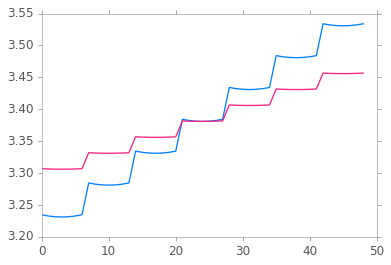

In [244]:
# case: only lens tilt about x-axis by 20 deg, pivot = ENPP
plt.plot(np.linalg.norm(k, axis=0))
plt.plot(np.linalg.norm(s, axis=0))

In [248]:
k[:, 0]

array([-0.1499075,  3.2310386])

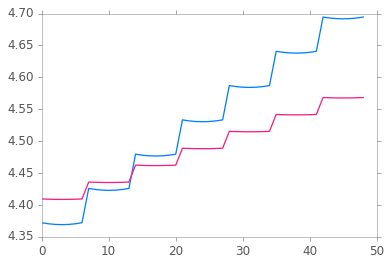

In [140]:
# case: only lens tilt about x-axis by 20 deg, pivot = 5 mm from ENPP
plt.plot(np.linalg.norm(k, axis=0))
plt.plot(np.linalg.norm(s, axis=0))

In [156]:
k = x2[:2, 49//2] - x1[:2, 49//2]
s = x4[:2, 49//2] - x3[:2, 49//2]

17.1707317

In [285]:
z = -509.0
d = -20.0
zoDash = 24.1707317
mp = 2.0
thetaXLens, thetaYLens =  5., 10.
thetaXImage, thetaYImage =  5, -2
Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
#Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))


A = np.array([[zoDash - d*Rl[2, 2],      0   ,   d*Rl[2, 0] ],
              [     0,    zoDash - d*Rl[2, 2],   d*Rl[2, 1] ],
              [     0,                   0,            1    ]
             ])

A

array([[ 43.7919369,   0.       ,   3.4597479],
       [  0.       ,  43.7919369,  -1.7431149],
       [  0.       ,   0.       ,   1.       ]])

In [286]:
np.linalg.matrix_rank(A)

3